# Exp: build Wasserstein GAN model for CIFAR10 with Keras

## Step1: load the data

In [33]:
import numpy as np
import matplotlib.pyplot as plt

In [34]:
def load_cifar10(label): # load the images of certain label from both train data and test data in cifar10
    from tensorflow.keras.datasets import cifar10
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    train_mask = [y[0]==label for y in y_train]
    test_mask = [y[0]==label for y in y_test]

    x_data = np.concatenate([x_train[train_mask], x_test[test_mask]])
    y_data = np.concatenate([y_train[train_mask], y_test[test_mask]])

    x_data = (x_data.astype('float32') - 127.5) / 127.5
 
    return (x_data, y_data)

In [35]:
label_map = {'airplane':0,'automobile':1,'bird':2,'cat':3,'deer':4,'dog':5,
             'frog':6,'horse':7,'ship':8,'truck':9}
(x_train,y_train) = load_cifar10(label_map['horse']) # take horse's images as example

In [36]:
print(x_train.shape)
print(y_train.shape)

(6000, 32, 32, 3)
(6000, 1)


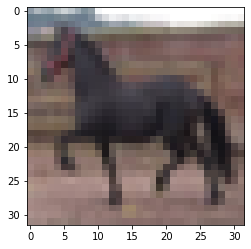

In [37]:
# show one of the horse's images
plt.imshow((x_train[250,:,:,:]+1)/2)

## Step2: define the WGAN's model strucutre

In [38]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,Flatten,Conv2D,Conv2DTranspose,Dropout,Reshape
from tensorflow.keras.layers import BatchNormalization,Activation,UpSampling2D,LeakyReLU
from tensorflow.keras import backend as K

z_dim = 100
generator_init_size = (4,4,128)
critic_learning_rate = 0.00005
generator_learning_rate = 0.00005
batch_size = 128
epochs = 3000
epoch_rate = 5
clip_threshold = 0.01

In [39]:
class WGAN():
    def __init__(self,z_dim,generator_init_size,critic_learning_rate,generator_learning_rate):
        self.z_dim = z_dim
        self.generator_init_size = generator_init_size
        self.critic_learning_rate = critic_learning_rate
        self.generator_learning_rate = generator_learning_rate
        
        self._build_model()
        self._compile_model()
        
        self.epoch_list = []
        self.c_losses = []
        self.g_losses = []
    def _build_model(self):
        # critic
        self._build_critic()
        # generator
        self._build_generator()
    def _build_critic(self):
        # input layer
        self.critic_input_layer = Input(shape=(32,32,3),name='critic_input')
        # conv layer 1
        x = Conv2D(
            filters = 32, kernel_size = (5,5),
            strides = 2, padding = 'same'
        )(self.critic_input_layer)
        x = LeakyReLU()(x)
        # conv layer 2
        x = Conv2D(
            filters = 64, kernel_size = (5,5),
            strides = 2, padding = 'same'
        )(x)
        x = LeakyReLU()(x)
        # conv layer 3
        x = Conv2D(
            filters = 128, kernel_size = (5,5),
            strides = 2, padding = 'same'
        )(x)
        x = LeakyReLU()(x)
        # conv layer 4
        x = Conv2D(
            filters = 128, kernel_size = (5,5),
            strides = 1, padding = 'same'
        )(x)
        x = LeakyReLU()(x)
        # flatten layer
        x = Flatten()(x)
        # dense layer / output layer
        self.critic_output_layer = Dense(
            units=1, name = 'critic_output',
            activation = None # no need to activate, cuz Wasserstein Distance range (-∞,+∞)
        )(x)
        
        self.critic = Model(self.critic_input_layer,self.critic_output_layer)
    def _build_generator(self):
        # input layer
        self.generator_input_layer = Input(shape=(self.z_dim,),name='generator_input')
        # dense layer
        x = Dense(units=np.prod(self.generator_init_size))(self.generator_input_layer)
        x = BatchNormalization(momentum = 0.8)(x)
        x = LeakyReLU()(x)
        x = Reshape(target_shape=self.generator_init_size)(x)
        # conv layer 1
        x = UpSampling2D()(x)
        x = Conv2D(
            filters = 128, kernel_size = (5,5),
            strides = 1, padding = 'same'
        )(x)
        x = BatchNormalization(momentum = 0.8)(x)
        x = LeakyReLU()(x)
        # conv layer 2
        x = UpSampling2D()(x)
        x = Conv2D(
            filters = 64, kernel_size = (5,5),
            strides = 1, padding = 'same'
        )(x)
        x = BatchNormalization(momentum = 0.8)(x)
        x = LeakyReLU()(x)
        # conv layer 3
        x = UpSampling2D()(x)
        x = Conv2D(
            filters = 32, kernel_size = (5,5),
            strides = 1, padding = 'same'
        )(x)
        x = BatchNormalization(momentum = 0.8)(x)
        x = LeakyReLU()(x)
        # conv layer 4 / output layer
        x = Conv2DTranspose(
            filters = 3, kernel_size = (5,5),
            strides = 1, padding = 'same'
        )(x)
        self.generator_output_layer = Activation('tanh')(x)
        
        self.generator = Model(self.generator_input_layer,self.generator_output_layer)
    def _compile_model(self):
        from tensorflow.keras.optimizers import RMSprop
        # compile critic
        self.critic.compile(
            optimizer = RMSprop(self.critic_learning_rate),
            loss = self.wasserstein
        )

        # frozen critic's weights when training generator
        self.set_trainable(self.critic, False)

        # compile generator
        model_input = Input(shape=(self.z_dim,), name='model_input')
        model_output = self.critic(self.generator(model_input))
        self.generator_training_model = Model(model_input, model_output)
        
        self.generator_training_model.compile(
            optimizer = RMSprop(self.critic_learning_rate),
            loss = self.wasserstein
        )
        
        # don't forget to unfrozen discriminator's weights
        self.set_trainable(self.critic, True)
    def fit_model(self,x_train,batch_size,epochs,epoch_rate,clip_threshold):
        ## train critic and generator in turns
        for epoch in range(epochs):
            # train critic => 
            # train critics epoch_rate times when training generator once
            # which is opposite to vanilla GAN, cuz we have to ensure the
            # gradient of critics is correct enough to criticize the generator
            for _ in range(epoch_rate): 
                c = self._fit_critic(x_train,batch_size,clip_threshold)
            # train generator
            g = self._fit_generator(batch_size)
            # log
            if epoch % (epochs//100) == 0:
                print("%d [C loss: (%.3f)(T %.3f, F %.3f)] | [G loss: %.3f]" % (epoch,c[0],c[1],c[2],g))
            self.c_losses.append(c)
            self.g_losses.append(g)
    def _fit_critic(self,x_train,batch_size,clip_threshold):
        # generate labels for supervising signals
        true_labels = np.ones(shape=(batch_size,1))
        false_labels = -np.ones(shape=(batch_size,1))
        # train on true images from x_train
        true_idx = np.random.randint(0,x_train.shape[0],batch_size)
        true_imgs = x_train[true_idx]
        c_loss_true = self.critic.train_on_batch(true_imgs,true_labels)
        # train on fake images from norm noise
        fake_noise = np.random.normal(0,1,(batch_size,self.z_dim))
        fake_imgs = self.generator.predict(fake_noise)
        c_loss_fake = self.critic.train_on_batch(fake_imgs,false_labels)
        
        # clip the weights to satisfy Lipschitz condition in a simple way
        for l in self.critic.layers:
            weights = l.get_weights()
            weights = [np.clip(w,-clip_threshold,clip_threshold) for w in weights]
            l.set_weights(weights)
        
        c_loss =  0.5 * (c_loss_true + c_loss_fake)
        return [c_loss, c_loss_true, c_loss_fake]
    def _fit_generator(self,batch_size):
        # generate labels for supervising signals
        true_labels = np.ones(shape=(batch_size,1))
        # train on fake images from norm noise
        fake_noise = np.random.normal(0,1,(batch_size,self.z_dim))
        return self.generator_training_model.train_on_batch(fake_noise,true_labels)
    def set_trainable(self, model, val):
        model.trainable = val
        for l in model.layers:
            l.trainable = val
    def wasserstein(self, y_true, y_pred):
        return - K.mean(y_true * y_pred)
    def critic_summary(self):
        self.critic.summary()
    def generator_summary(self):
        self.generator.summary()

## Step3: compile and train the model

In [40]:
wgan = WGAN(z_dim,generator_init_size,critic_learning_rate,generator_learning_rate)

In [41]:
wgan.critic_summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
critic_input (InputLayer)    [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 32)        2432      
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 64)          51264     
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 4, 4, 128)         204928    
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 4, 4, 128)         0   

In [42]:
wgan.generator_summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) [(None, 100)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              206848    
_________________________________________________________________
batch_normalization_8 (Batch (None, 2048)              8192      
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 2048)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 128)         0         
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 8, 8, 128)         4097

In [43]:
wgan.fit_model(x_train,batch_size,epochs,epoch_rate,clip_threshold)

0 [C loss: (-0.000)(T -0.000, F 0.000)] | [G loss: -0.000]
30 [C loss: (-0.011)(T -0.003, F -0.019)] | [G loss: 0.043]
60 [C loss: (-0.022)(T 0.027, F -0.070)] | [G loss: 0.076]
90 [C loss: (-0.043)(T 0.023, F -0.109)] | [G loss: 0.133]
120 [C loss: (-0.057)(T -0.018, F -0.097)] | [G loss: 0.147]
150 [C loss: (-0.080)(T -0.009, F -0.151)] | [G loss: 0.180]
180 [C loss: (-0.085)(T -0.017, F -0.153)] | [G loss: 0.279]
210 [C loss: (-0.078)(T 0.027, F -0.183)] | [G loss: 0.328]
240 [C loss: (-0.093)(T 0.017, F -0.203)] | [G loss: 0.332]
270 [C loss: (-0.081)(T 0.001, F -0.163)] | [G loss: 0.326]
300 [C loss: (-0.085)(T -0.059, F -0.111)] | [G loss: 0.325]
330 [C loss: (-0.092)(T -0.050, F -0.133)] | [G loss: 0.373]
360 [C loss: (-0.107)(T -0.020, F -0.193)] | [G loss: 0.427]
390 [C loss: (-0.140)(T 0.018, F -0.299)] | [G loss: 0.509]
420 [C loss: (-0.149)(T -0.056, F -0.242)] | [G loss: 0.528]
450 [C loss: (-0.095)(T -0.002, F -0.187)] | [G loss: 0.578]
480 [C loss: (-0.153)(T 0.006, F -0

## Step4: show the loss curve

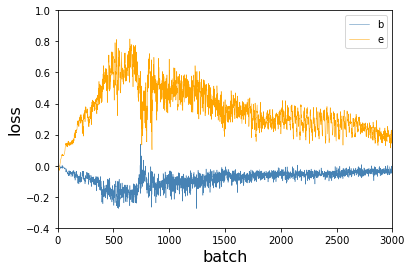

In [48]:
import matplotlib.pyplot as plt

# draw loss curve
fig = plt.figure()

plt.plot([x[0] for x in wgan.c_losses], color='steelblue', linewidth=0.5,label='c_avg_loss')
# plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.25,label='d_true_loss')
# plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.25,label='d_fake_loss')
plt.plot(wgan.g_losses, color='orange', linewidth=0.5,label='g_loss')

plt.xlabel('batch', fontsize=16)
plt.ylabel('loss', fontsize=16)

plt.xlim(0, epochs)
plt.ylim(-0.4, 1)

plt.legend('best')

plt.show()

## Step5: show the generation effect

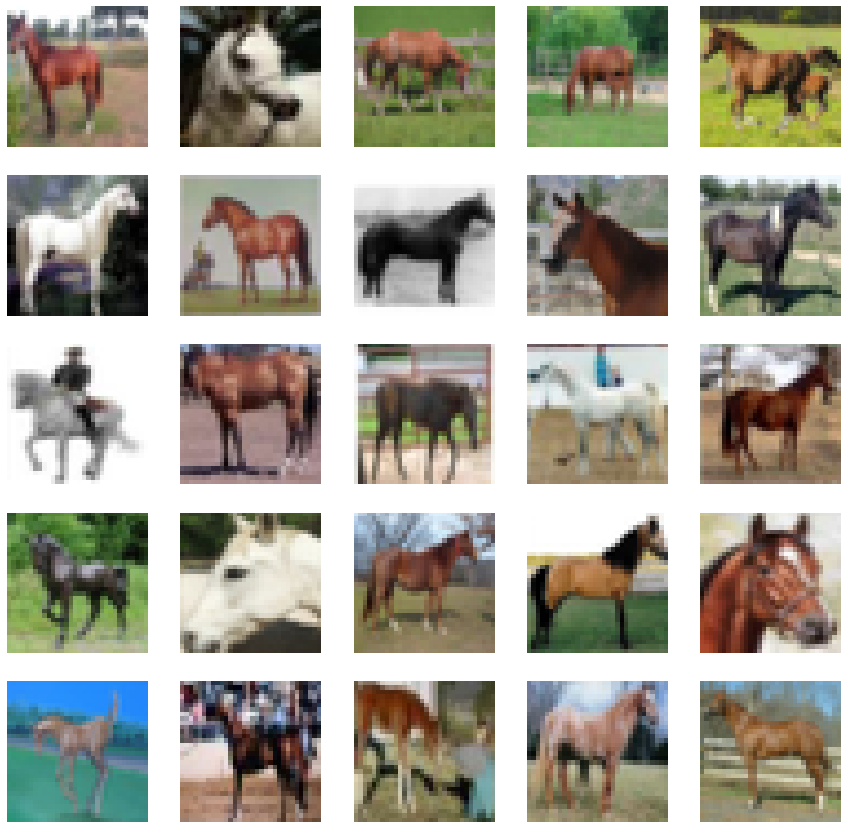

In [49]:
## original images show
r,c = 5,5

idx = np.random.randint(0, x_train.shape[0], batch_size)
true_imgs = (x_train[idx] + 1) *0.5

fig, axs = plt.subplots(r, c, figsize=(15,15))
cnt = 0

for i in range(r):
    for j in range(c):
        axs[i,j].imshow(true_imgs[cnt], cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1

plt.show()
plt.close()

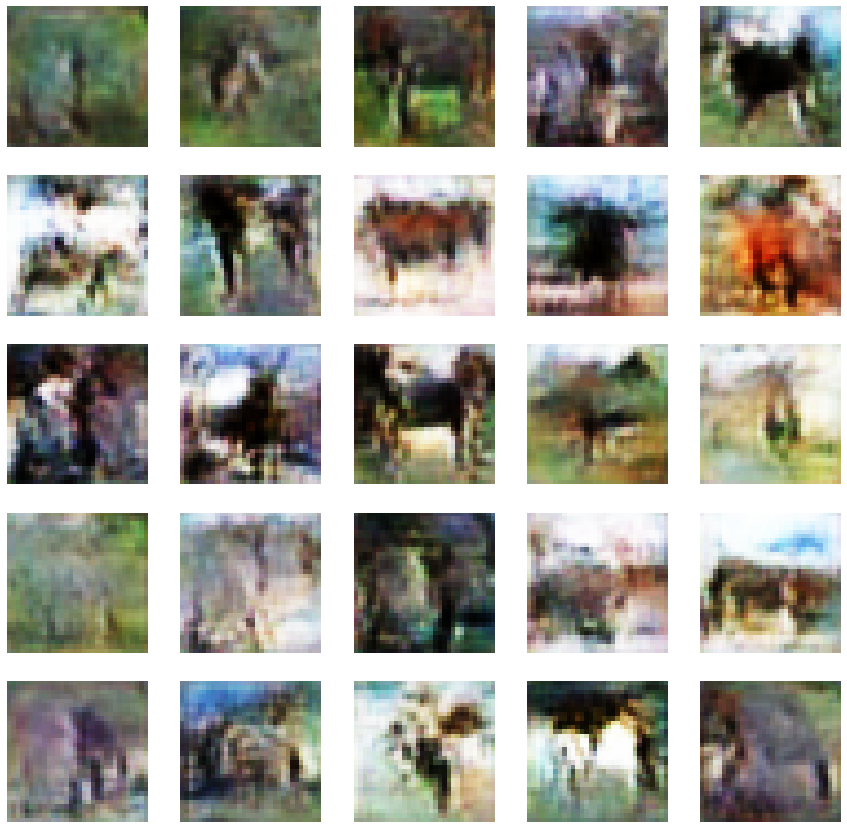

In [60]:
## new generated images by generator
r,c = 5,5
noise = np.random.normal(0, 1, (r * c, wgan.z_dim))
gen_imgs = wgan.generator.predict(noise)

#Rescale images 0 - 1

gen_imgs = 0.5 * (gen_imgs + 1)
gen_imgs = np.clip(gen_imgs, 0, 1)

fig, axs = plt.subplots(r, c, figsize=(15,15))
cnt = 0

for i in range(r):
    for j in range(c):
        axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]), cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1

plt.show()
plt.close()

## Step6: find the closest image for the generation

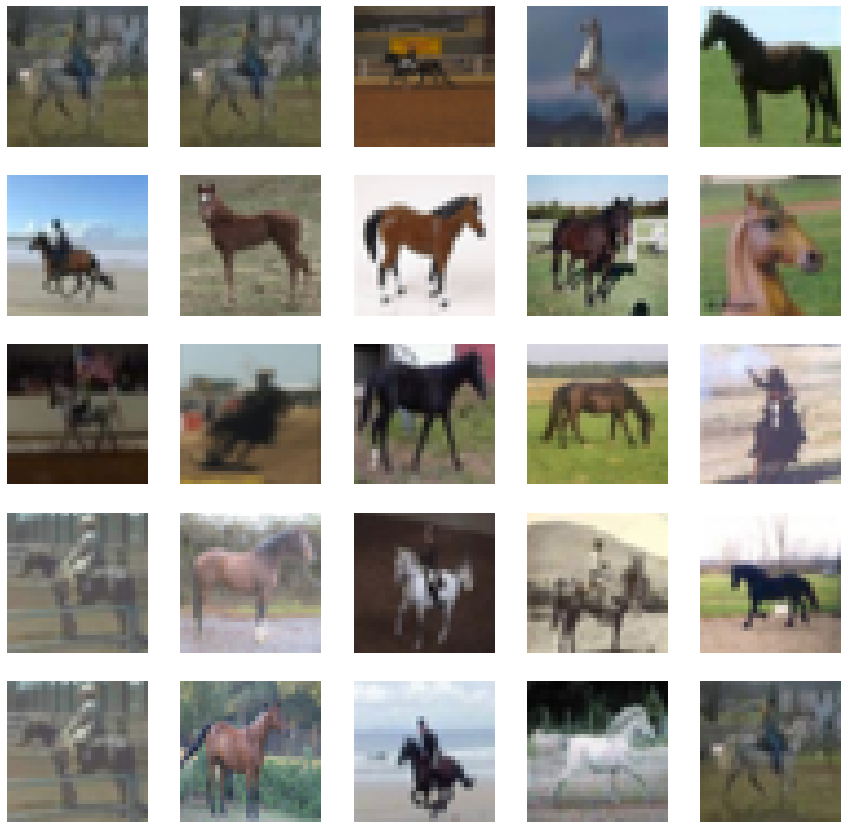

In [61]:
fig, axs = plt.subplots(r, c, figsize=(15,15))
cnt = 0

def l1_mean_distance(img1, img2):
    return np.mean(np.abs(img1 - img2))

for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate((x_train + 1) * 0.5):
            
            diff = l1_mean_distance(gen_imgs[cnt, :,:,:], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i,j].imshow(c_img, cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1

plt.show()
plt.close()